In [7]:
import numpy as np
from typing import Any, cast, List
from enum import Enum

class Side(Enum):
    LONG = 1
    SHORT = 2
    def __str__(self):
        return "Long" if self==Side.LONG else "Short"

class Kind(Enum):
    CALL = 1
    PUT = 2
    def __str__(self):
        return "Call" if self==Kind.CALL else "Put"


class Option:
    def __init__(self, kind:Kind, side:Side, strike:float, premium:float):
        self.kind = kind
        self.side = side
        self.premium = premium
        self.strike = strike

    def __str__(self):
        return f'{self.side} {self.kind} S={self.strike} p={self.premium}'
    
    def __repr__(self) -> str:
        return self.__str__()
        



In [8]:
# long put otm strike
# short put near strike
# short call near strike
# long call otm strike 


from matplotlib import pyplot as plt


def option_pnl(market_price_expiry:np.ndarray, option:Option) -> np.ndarray:
    if option.kind == Kind.PUT:
        intrinsic_value = np.maximum(option.strike - market_price_expiry, 0)
    else:  # Kind.CALL
        intrinsic_value = np.maximum(market_price_expiry - option.strike, 0)

    if option.side == Side.LONG:
        pnl = intrinsic_value - option.premium
    else:  # Side.SHORT
        pnl = option.premium - intrinsic_value

    return pnl

def ironcondor_pnl(market_price_expiry:np.ndarray,                                
                   long_put_otm:Option,
                   short_put_near:Option,
                   short_call_near:Option,
                   long_call_otm:Option) -> np.ndarray:
    return option_pnl(market_price_expiry, long_call_otm) + \
           option_pnl(market_price_expiry, long_put_otm) + \
           option_pnl(market_price_expiry, short_call_near) + \
           option_pnl(market_price_expiry, short_put_near)

def plot_collar_strategy(market_price_open:float, 
                         long_put_otm:Option, short_put_near:Option, short_call_near:Option, long_call_otm:Option)-> None:

    global plt
    net_premium = (short_put_near.premium + short_call_near.premium) - (long_put_otm.premium + long_call_otm.premium)
    break_even_lower = short_put_near.strike - net_premium
    break_even_upper = short_call_near.strike + net_premium    

    market_prices_expiry = np.linspace(market_price_open * 0.01, market_price_open * 2, 200)
    pnls:np.ndarray = ironcondor_pnl(market_prices_expiry, long_call_otm, long_put_otm, short_call_near, short_put_near)

    plt = cast(Any, plt)  # Pylance: matplotlib stubs are incomplete.

    linewidth=1.3
    plt.figure(figsize=(15, 5))
    plt.plot(market_prices_expiry, pnls, label='Iron Condor Strategy PnL', color='blue')
    plt.axhline(0, color='gray', linestyle='--', linewidth=linewidth, label='Break-even line')
    plt.axvline(market_price_open, color='green', linestyle='-', linewidth=2*linewidth)
    plt.axvline(long_put_otm.strike, color='#FF0000', linestyle=':', linewidth=linewidth, label='Long Put OTM')    # bright red
    plt.axvline(short_put_near.strike, color='#FF6666', linestyle=':', linewidth=linewidth, label='Short Put Near')  # light red
    plt.axvline(short_call_near.strike, color='#B22222', linestyle=':', linewidth=linewidth, label='Short Call Near')  # firebrick
    plt.axvline(long_call_otm.strike, color='#8B0000', linestyle=':', linewidth=linewidth, label='Long Call OTM')   # dark red
    plt.axvline(break_even_lower, color='#8B0000', linestyle='--', linewidth=1.5*linewidth, label='Lower Break-even')   # dark red
    plt.axvline(break_even_upper, color='#B22222', linestyle='--', linewidth=1.5*linewidth, label='Upper Break-even')   # firebrick red

    ax = plt.gca()
    ax.set_ylim(pnls.min()*1.1, pnls.max()*1.1)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    pnl_samples_idx:List[int] = [] # list(range(0, len(pnls), 15)) + [len(pnls) - 1] # use this to zoom out if needed
    xticks = sorted([
        long_put_otm.strike, short_put_near.strike,
        short_call_near.strike, long_call_otm.strike,
        break_even_lower, break_even_upper,  market_price_open]
        +
        [pnls[idx] for idx in pnl_samples_idx]
        )
    xticklabels = [''] * len(xticks)
    xticklabels = [''] * len(xticks)
    xticklabels[xticks.index(long_put_otm.strike)] = f'{long_put_otm.strike} Long Put OTM'
    xticklabels[xticks.index(short_put_near.strike)] = f'{short_put_near.strike} Short Put Near'
    xticklabels[xticks.index(short_call_near.strike)] = f'{short_call_near.strike} Short Call Near'
    xticklabels[xticks.index(long_call_otm.strike)] = f'{long_call_otm.strike} Long Call OTM'
    xticklabels[xticks.index(break_even_lower)] = f'{break_even_lower} L Break-even'
    xticklabels[xticks.index(break_even_upper)] = f'{break_even_upper} U Break-even'
    xticklabels[xticks.index(market_price_open)] = f'{market_price_open} Market Open'
    idx:int
    for idx in pnl_samples_idx:
        xticklabels[xticks.index(pnls[idx])] = f'{pnls[idx]}'

    ax.set_xlim(long_put_otm.strike*0.9, long_call_otm.strike*1.1)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)


    plt.title('Iron Condor Strategy PnL at Expiry')
    plt.xlabel('Market Price at Expiry')
    plt.ylabel('Profit/Loss (PnL)')
    plt.grid(True, linestyle='--', alpha=0.7)
    # plt.legend(
    #     loc="center left",
    #     bbox_to_anchor=(1.02, 0.5),
    #     borderaxespad=0.0
    #     )
    plt.tight_layout()
    plt.show()
    plt.show()

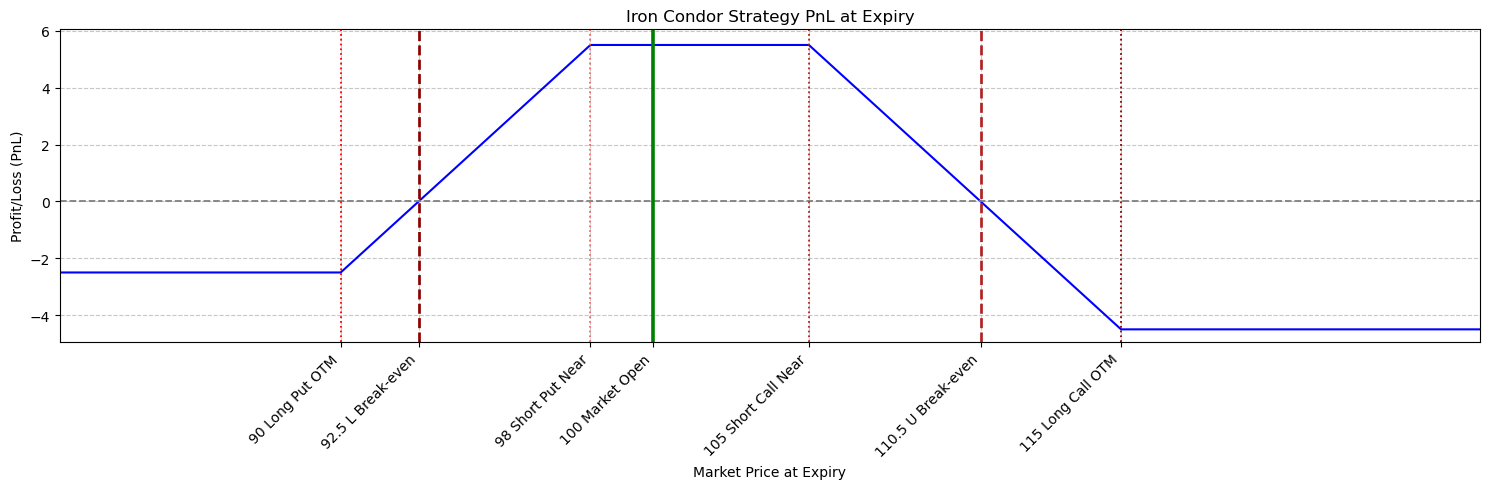

In [9]:
options: List[Option] = [
    Option(Kind.PUT,  Side.LONG,  90,  1.00),
    Option(Kind.PUT,  Side.SHORT, 98,  2.50),
    Option(Kind.CALL, Side.SHORT, 105, 4.75),
    Option(Kind.CALL, Side.LONG,  115, 0.75),
]

spot_price = 100  # Market at time of purchase
plot_collar_strategy(spot_price, *options)

